# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [106]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
from operator import itemgetter
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [107]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
azdias = pd.read_csv('azdias.csv', sep=',')

In [108]:
azdias.shape

(891221, 367)

In [109]:
del azdias['Unnamed: 0']

In [110]:
#first rows of the azdias dataframe
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [111]:
# summary statistics information
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [112]:
# converting all int64 columns to float64 type since it leads to some problems on dummy values stage and imputer
for col in azdias.columns:
    if azdias[col].dtype == np.int64:
        azdias[col] = azdias[col].astype(np.float64)

In [113]:
# Load the feature information
# feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
# del feat_info['Unnamed: 0']
feat_info = pd.read_csv('feat_info.csv')
#del feat_info['Unnamed: 0']
feat_info

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [114]:
# the feature info table only the first row is filled in, so we need to fill the rest NAs and redefine it 
# as an Attribute column
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute
feat_info

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [115]:
# find all the encoded values which are missing or unknow that should be converted to NaNs. So select all the 
# fields which have unknown or no ine Meaning column
feat_info_unknown = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
feat_info_unknown

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [116]:
feat_info_unknown.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [117]:
# now let's combine in one list all the missing or unknown values for each "feature/columns" in one row for each feature 
# instead of few as it looks now
unknown_val = []
for attribute in feat_info_unknown['Attribute'].unique():
    val = feat_info_unknown.loc[feat_info['Attribute'] == attribute, 
                                        'Value'].astype(str).str.cat(sep=',').split(',')
    unknown_val.append(val)
feat_info_unknown = pd.concat([pd.Series(feat_info_unknown['Attribute'].unique()), pd.Series(unknown_val)], axis=1)

In [118]:
feat_info_unknown.columns = ['attribute', 'missing_or_unknown']
feat_info_unknown

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


In [119]:
feat_info_unknown['attribute'].values.tolist()

['AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'BALLRAUM',
 'BIP_FLAG',
 'CAMEO_DEUG_2015',
 'CAMEO_DEUINTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTI

In [120]:
# now we now which missing or uknown values should be converted to NaNs using feature_info_unknown
import time
start = time.time()
    
for row in feat_info_unknown['attribute']:
    if row in azdias.columns.values.tolist():
        print(row)
        na_map = feat_info_unknown.loc[feat_info_unknown['attribute'] == row, 'missing_or_unknown'].iloc[0]
        #na_map = list(map(str.strip, na_map.strip('][').replace("'", '').split(',')))
        na_idx = azdias.loc[:, row].isin(na_map)
        azdias.loc[na_idx, row] = np.NaN
    else:
        continue

end = time.time()

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
CAMEO_DEUG_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_ONLINE_QUOTE_12
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
EWDICHTE
FINANZTYP
FINANZ_ANLEGER
FINANZ_HAUSBAUER
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_UNAUFFAELLIGER
FINANZ_VORSORGER
GEBAEUDETYP
HEALTH_TYP
HH_EINKOMMEN_SCORE
INNENSTADT
KBA05_ALTER1
KBA05_ALTER2
KBA05_ALTER3
KBA05_ALTER4
KBA05_ANHANG
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_AUTOQUOT
KBA05_BAUMAX
KBA05_CCM1
KBA05_CCM2
KBA05_CCM3
KBA05_CCM4
KBA05_DIESEL
KBA05_FRAU
KBA0

In [121]:
#azdias.to_csv("azdias_1.csv", header=True)

In [122]:
azdias.shape

(891221, 366)

In [123]:
#feat_info_unknown.to_csv("feat_info_unknown.csv", header=True)

In [124]:
# azdias = pd.read_csv("azdias.csv")
# del azdias['Unnamed: 0']
# feat_info_unknown = pd.read_csv("feat_info_unknown.csv")
# del feat_info_unknown['Unnamed: 0']

In [125]:
# missing_per_column_percent =((azdias.isnull().sum()/len(azdias))*100)
# missing_per_column_percent.sort_values(ascending=False)

In [126]:
# number of missed values per column
missing_per_column_percent =azdias.isnull().sum()
missing_per_column_percent.sort_values(ascending=False)

ALTER_KIND4                    890016
TITEL_KZ                       889061
ALTER_KIND3                    885051
D19_TELKO_ONLINE_DATUM         883018
D19_BANKEN_OFFLINE_DATUM       871535
ALTER_KIND2                    861722
D19_TELKO_ANZ_12               857990
D19_BANKEN_ONLINE_QUOTE_12     845987
D19_BANKEN_ANZ_12              831734
D19_TELKO_ANZ_24               826208
D19_VERSI_ANZ_12               821289
D19_TELKO_OFFLINE_DATUM        819114
ALTER_KIND1                    810163
D19_BANKEN_ANZ_24              794100
D19_VERSI_ANZ_24               777037
KBA05_ANTG4                    733495
D19_BANKEN_ONLINE_DATUM        726982
AGER_TYP                       685843
D19_BANKEN_DATUM               678331
D19_VERSAND_ONLINE_QUOTE_12    674480
D19_TELKO_DATUM                665798
EXTSEL992                      654153
D19_GESAMT_ONLINE_QUOTE_12     650188
KBA05_ANTG3                    644869
D19_VERSAND_ANZ_12             637972
D19_VERSAND_OFFLINE_DATUM      634233
D19_GESAMT_A

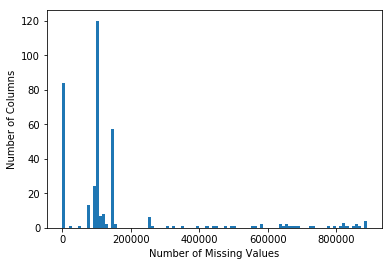

In [127]:
# let's build a histogramm which shows the relationship between number of missed values per column
# we see 2 groups of columns and the threshold we can set to 2000000
plt.hist(missing_per_column_percent, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Number of Missing Values')
plt.show()

In [128]:
# colums_to_drop = missing_per_column_percent[missing_per_column_percent > 17]
# colums_to_drop.sort_values()
# let's see the columns where number of missed values > 200000 and drop them
colums_to_drop = missing_per_column_percent[missing_per_column_percent > 200000]
colums_to_drop.sort_values()

D19_KONSUMTYP                  257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_SOZIALES                   257113
D19_LOTTO                      257113
D19_LETZTER_KAUF_BRANCHE       257113
ALTERSKATEGORIE_FEIN           262947
ALTER_HH                       310267
KBA05_MAXVORB                  327055
D19_GESAMT_DATUM               354170
KBA05_ANTG1                    394373
KBA05_ANTG2                    425862
D19_VERSAND_DATUM              437886
D19_GESAMT_ONLINE_DATUM        450995
KBA05_BAUMAX                   476524
D19_VERSAND_ONLINE_DATUM       494464
D19_GESAMT_ANZ_24              505303
D19_GESAMT_OFFLINE_DATUM       558558
D19_VERSAND_ANZ_24             563818
KK_KUNDENTYP                   584612
D19_GESAMT_ANZ_12              584797
D19_VERSAND_OFFLINE_DATUM      634233
D19_VERSAND_ANZ_12             637972
KBA05_ANTG3                    644869
D19_GESAMT_ONLINE_QUOTE_12     650188
EXTSEL992                      654153
D19_TELKO_DA

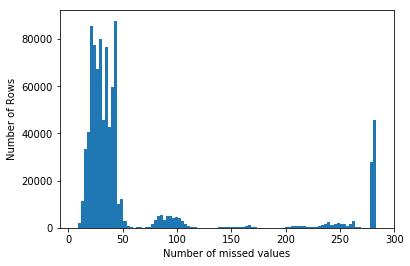

In [129]:
# let's do the same procedure for rows - we that a lot of rows have not more than 50 missed values
missed_data_per_row =azdias.isnull().sum(axis=1)
plt.hist(missed_data_per_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of missed values')
plt.show()

In [130]:
#feat_info_att = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')
feat_info_att = pd.read_csv('feat_info_att.csv', sep=',', skiprows = 1)
#del feat_info_att['Unnamed: 0']
feat_info_att

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [131]:
# these columns we desided to drop, 47 columns out of initial 366 which is around 13%. Many of them are starting
# with D19 which are about transaction activity.
colums_to_drop.index.tolist()

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_BAUMAX',
 'KBA05_MAXVORB',
 'KK_KUNDE

In [132]:
# dropping rows with more than 10 missed values in each
row_na = azdias.shape[1] - azdias.count(axis = 1)
rows_to_drop = azdias.index[row_na > 10]
azdias.drop(rows_to_drop, axis=0, inplace = True)

## Select and Re-Encode Features

From the project in Term1: Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (feat_info) for a summary of types of measurement.

For numeric and interval data, these features can be kept without changes.
Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the capstone project we don't have a columns which tells us the type of columns values so I had manually to go through the data, so this list might be not accurate.

In [133]:
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [134]:
data = azdias
#del data['Unnamed: 0']

In [135]:
# drop the columns we selected earlier
data.drop(colums_to_drop.index.tolist(), axis = 1, inplace = True)

In [136]:
# let's go through categorial columns and check what unique values they have in each columns
for i in categorical:
    if i in data.columns:
        print(i, len(data[i].value_counts()), data[i].unique().tolist())

ANREDE_KZ 2 [2.0, 1.0]
CAMEO_DEU_2015 45 ['8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D', '7A', '5D', '9E', '5C', '9B', '1B', '8B', '3D', nan, '4E', '4B', '3C', '5A', '7B', '9A', '6E', '6D', '2C', '7C', '9C', '7D', '5E', '1D', '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F', '1C', 'XX']
CJT_GESAMTTYP 6 [5.0, 3.0, 2.0, 4.0, 1.0, 6.0, nan]
FINANZTYP 6 [1.0, 6.0, 5.0, 2.0, 4.0, 3.0]
GEBAEUDETYP 7 [8.0, 1.0, 3.0, 2.0, 6.0, 4.0, 5.0]
GEBAEUDETYP_RASTER 5 [3.0, 4.0, 5.0, 2.0, 1.0, nan]
GFK_URLAUBERTYP 12 [10.0, 1.0, 5.0, 12.0, 9.0, 3.0, 8.0, 11.0, 4.0, 7.0, 2.0, 6.0, nan]
HEALTH_TYP 3 [3.0, 2.0, 1.0, nan]
KBA05_HERSTTEMP 5 [4.0, 3.0, 1.0, 2.0, 5.0, nan]
KBA05_MAXHERST 5 [2.0, 5.0, 3.0, 1.0, 4.0]
KBA05_MODTEMP 6 [1.0, 4.0, 3.0, 2.0, 5.0, 6.0]
LP_FAMILIE_FEIN 12 [5.0, 1.0, 0.0, 10.0, 2.0, 7.0, 11.0, 8.0, 4.0, 6.0, nan, 9.0, 3.0]
LP_FAMILIE_GROB 6 [3.0, 1.0, 0.0, 5.0, 2.0, 4.0, nan]
LP_LEBENSPHASE_FEIN 41 [21.0, 3.0, 0.0, 32.0, 8.0, 2.0, 5.0, 10.0, 4.0, 6.0, 20.0, 1

In [137]:
# replacing characters with 1 and 0
data['OST_WEST_KZ'].replace(['W', 'O'], [1.0, 0.0], inplace=True)
data['OST_WEST_KZ'].head()

1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: OST_WEST_KZ, dtype: float64

In [138]:
# algorithm for columns selection isthe  following: if a column has more than 10 unique values -> then drop it,
# if less - dummy it
columns_2drop = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN',
                 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
#columns_2dummy = [col for col in categorical if col not in columns_2drop]
columns_2dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
print(columns_2dummy)

['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']


In [139]:
# making sure we've droppped the columns by checking data frame size
print("before drop ", data.shape)
data.drop(columns_2drop, axis=1, inplace = True)
print("after drop", data.shape)

before drop  (732828, 319)
after drop (732828, 311)


In [140]:
# data = pd.read_csv("azdias_in_dummy.csv")
# del data['Unnamed: 0']

In [141]:
#data.to_csv("azdias.csv", header=True)

In [142]:
# now let's do a dummy value procedure and print the columns being dummied
for col in columns_2dummy:
    print(col)
    dummy = pd.get_dummies(data[col], prefix = col)
    data = pd.concat([data, dummy], axis = 1)
    #data.to_csv("azdias_in_dummy" + ".csv", header=True)

CJT_GESAMTTYP
FINANZTYP
GEBAEUDETYP
GEBAEUDETYP_RASTER
HEALTH_TYP
KBA05_HERSTTEMP
KBA05_MAXHERST
KBA05_MODTEMP
LP_FAMILIE_GROB
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
VERS_TYP


In [143]:
data.shape

(732828, 374)

In [144]:
data.to_csv("azdias1.csv", header=True)

In [145]:
#data = pd.read_csv("azdiasZABEOTYP.csv")

In [146]:
#feat_info_unknown = pd.read_csv("feat_info_unknown.csv")

In [147]:
# here we are defining a clean_data method (like in the project from term1) to perform all the steps
# we did in the cells above for the azdias dataset
def clean_data(df, df_info):
    
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col] = df[col].astype(np.float64)
           
    # convert missing values into NaNs
    for row in df_info['attribute']:
        if row in df.columns:
            na_map = df_info.loc[df_info['attribute'] == row, 'missing_or_unknown'].iloc[0]
            #na_map = list(map(str.strip, na_map.strip('][').replace("'", '').split(',')))
            na_idx = df.loc[:, row].isin(na_map)
            df.loc[na_idx, row] = np.NaN
        else:
            continue
            
   
    # drop all the columns the same as we did for azdias dataset
    cols_2drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
                  'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM',
                  'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
                  'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
                  'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 
                  'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12',
                  'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
                  'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
                  'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
                  'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12','D19_VERSI_ANZ_24', 
                  'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
                  'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
   
    df.drop(cols_2drop, axis=1, inplace = True)
    
    # if number of missed values in a row is > 10 -> delete row
    row_na = df.shape[1] - df.count(axis = 1)
    rows_to_drop = df.index[row_na > 10]
    df.drop(rows_to_drop, axis=0, inplace = True)
    
    # re-encode values
    df['OST_WEST_KZ'].replace(['W', 'O'], [1.0, 0.0], inplace=True)
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col] = df[col].astype(np.float64)

    # engineer columns and drop the columns where number of unique values > 10
    categorical = ['ANREDE_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP',
                   'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
                   'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
                   'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN',
                   'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE',
                   'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP']
    
    columns_2drop = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN',
                     'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
    columns_2dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                        'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                        'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    df.drop(columns_2drop, axis=1, inplace = True)
    
    for col in columns_2dummy:
        dummy = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dummy], axis = 1)
    return df

In [148]:
# load customers dataset
customers = pd.read_csv('customers.csv', sep=',')

In [149]:
customers.shape

(191652, 370)

In [150]:
del customers['Unnamed: 0']

In [151]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [152]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [153]:
#feat_info_uknown = pd.read_csv("feat_info_unknown.csv")

In [154]:
# perform cleaning on customers dataset
customers = clean_data(customers, feat_info_unknown)

In [155]:
# list the columns which are in the customers dataeste but missed in azdias dataset
(set(customers.columns.values.tolist()).difference(data.columns.values.tolist()))

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [156]:
len(data.columns.unique().tolist())

374

In [157]:
len(customers.columns.values.tolist())

376

In [158]:
data.shape

(732828, 374)

In [181]:
# list the columns which are in azdias dataset but missed in the customers dataset
data.columns[~data.columns.isin(customers.columns)]

Index(['GEBAEUDETYP_5.0'], dtype='object')

We see that in customers dataset the column GEBAEUDETYP_5.0 is missed, so let's create it there. We check first 
what is the index of this columns in azdias dataset and insert it in the same place

In [182]:
index = data.columns.get_loc("GEBAEUDETYP_5.0")
index

327

In [183]:
customers.insert(loc=index, column='GEBAEUDETYP_5.0', value=0)

In [184]:
# now we see the number of columns in customers dataset is bigger for these three columns 
# {'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'} that in aZdias dataset. But that is
# expected
print(customers.shape[1])
print(data.shape[1] + 3)

377
377


In [185]:
# just temroray save azdias data set
data.to_csv("azdias_clean.csv", header = True)

In [186]:
# just temroray save customers data set
customers.to_csv("customers_clean.csv", header = True)

In [187]:
customers_clean = customers
azdias_clean = data

## Impute Missing Values

In [188]:
azdias_clean = pd.read_csv("azdias_clean.csv")

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [189]:
customers_clean = pd.read_csv("customers_clean.csv")

In [190]:
del azdias_clean['Unnamed: 0']
del customers_clean['Unnamed: 0']

In [191]:
azdias_clean.shape, customers_clean.shape

((732828, 374), (134246, 377))

In [192]:
# for col in customers_clean.columns:
#     print(col, customers_clean[col].unique().tolist())

In [193]:
# for col in azdias_clean.columns:
#     print(col, azdias_clean[col].unique().tolist())

In [194]:
# removing these columns for simplicity because Imputer won't work because these columns have Strings 'X, XX'
# among values
customers_clean.drop(['CAMEO_INTL_2015', 'EINGEFUEGT_AM'], axis = 1, inplace = True)

In [195]:
# removing these columns for simplicity because Imputer won't work because these columns have Strings 'X, XX'
# among values
azdias_clean.drop(['CAMEO_INTL_2015', 'EINGEFUEGT_AM'], axis = 1, inplace = True)

In [196]:
# saving these 3 columns in a separate dateframe for later
customers_additional_cols = customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]
customers_additional_cols.head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0
1,COSMETIC_AND_FOOD,MULTI_BUYER,0.0
2,COSMETIC,MULTI_BUYER,0.0
3,FOOD,MULTI_BUYER,0.0
4,COSMETIC_AND_FOOD,MULTI_BUYER,0.0


In [197]:
# deleting these 3 columns from customers dataset to have the same set of columns from both datasets
customers_clean.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis = 1, inplace = True)

In [198]:
#azdias_clean.drop(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis = 1, inplace = True)

In [199]:
# making sure we have the same set of columns in customers and azdias dataframes
azdias_clean.shape, customers_clean.shape

((732828, 372), (134246, 372))

In [200]:
azdias_clean.columns.tolist()

['LNR',
 'AKT_DAT_KL',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSICHERUNGEN',
 'D19_VOLLSORTI

In [201]:
#len(azdias_clean['D19_UNBEKANNT'].unique().tolist())

In [202]:
# let's use Imputer to fill missed values as column mean value
imputer = Imputer()
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias_clean), columns = azdias_clean.columns)

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [203]:
customers_clean = pd.DataFrame(imputer.transform(customers_clean), columns = customers_clean.columns)

In [204]:
azdias_clean.columns

Index(['LNR', 'AKT_DAT_KL', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'ANZ_KINDER', 'ANZ_PERSONEN', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       'ARBEIT', 'BALLRAUM',
       ...
       'LP_STATUS_GROB_5.0', 'NATIONALITAET_KZ_1.0', 'NATIONALITAET_KZ_2.0',
       'NATIONALITAET_KZ_3.0', 'SHOPPER_TYP_0.0', 'SHOPPER_TYP_1.0',
       'SHOPPER_TYP_2.0', 'SHOPPER_TYP_3.0', 'VERS_TYP_1.0', 'VERS_TYP_2.0'],
      dtype='object', length=372)

In [205]:
# check if we still have missed values in columns in azdias dataframe
azdias_clean.isnull().sum()

LNR                           0
AKT_DAT_KL                    0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
D19_BILDUNG                   0
D19_BIO_OEKO                  0
D19_BUCH_CD                   0
D19_DIGIT_SERV                0
D19_DROGERIEARTIKEL           0
D19_ENERGIE                   0
                             ..
KBA05_MA

In [206]:
# check if we still have missed values in columns in customers dataframe
customers_clean.isnull().sum()

LNR                           0
AKT_DAT_KL                    0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
D19_BILDUNG                   0
D19_BIO_OEKO                  0
D19_BUCH_CD                   0
D19_DIGIT_SERV                0
D19_DROGERIEARTIKEL           0
D19_ENERGIE                   0
                             ..
KBA05_MA

## Feature Scaling

In [207]:
# Apply feature Scalling
scaler = StandardScaler()
azdias_clean = pd.DataFrame(scaler.fit_transform(azdias_clean), columns = azdias_clean.columns)
customers_clean = pd.DataFrame(scaler.transform(customers_clean), columns = customers_clean.columns)

In [208]:
# print few first lines after scalling
customers_clean.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-2.436350,-0.933133,-0.475373,-1.260357e-01,-0.299688,0.221778,-0.473035,-0.06068,-2.190806,-0.522583,...,2.450209,0.43888,-0.296136,-0.206002,-0.449632,-0.659514,-0.602167,1.888753,1.099268,-1.007072
1,-1.915518,-0.933133,-0.475373,-1.260357e-01,-0.299688,-0.636695,-0.473035,-0.06068,-0.179463,1.307937,...,2.450209,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.529450,-0.909696,0.992978
2,-1.915514,-0.933133,-0.541737,-2.239786e-17,-0.299688,-1.495167,-0.473035,-0.06068,-2.190806,1.307937,...,-0.408128,0.43888,-0.296136,-0.206002,2.224039,-0.659514,-0.602167,-0.529450,1.099268,-1.007072
3,-1.915510,-0.933133,-0.077190,-1.260357e-01,-0.299688,1.938724,-0.031015,-0.06068,-0.179463,-0.522583,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.529450,-0.909696,0.992978
4,-1.915456,-0.933133,-0.475373,-1.260357e-01,-0.299688,0.221778,-0.473035,-0.06068,-0.179463,1.307937,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.529450,-0.909696,0.992978


In [209]:
# print few first lines after scalling
azdias_clean.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1.057669,1.264278,0.188265,-0.126036,-0.299688,0.221778,0.337336,-0.06068,-0.179463,0.850307,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,-0.659514,-0.602167,1.888753,-0.909696,0.992978
1,1.057688,1.264278,0.121902,-0.126036,-0.299688,-0.636695,-0.031015,-0.06068,-0.179463,-0.980213,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,-0.659514,1.660669,-0.529450,1.099268,-1.007072
2,1.057692,-0.933133,-0.475373,-0.126036,-0.299688,-1.495167,-0.399365,-0.06068,-1.185135,-0.064953,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.529450,1.099268,-1.007072
3,1.057750,-0.933133,-0.342645,-0.126036,-0.299688,1.938724,-0.325695,-0.06068,0.826209,-0.980213,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,-0.659514,1.660669,-0.529450,-0.909696,0.992978
4,1.057762,-0.933133,-0.209917,-0.126036,-0.299688,-0.636695,-0.399365,-0.06068,-1.185135,0.850307,...,-0.408128,0.43888,-0.296136,-0.206002,2.224039,-0.659514,-0.602167,-0.529450,-0.909696,0.992978


In [210]:
# save temproraial results
azdias_clean.to_csv("azdias_final.csv", header = True)
customers_clean.to_csv("customers_final.csv", header = True)

In [211]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [212]:
azdias_final = pd.read_csv("azdias_final.csv")
customers_final = pd.read_csv("customers_final.csv")

In [213]:
del azdias_final['Unnamed: 0']
del customers_final['Unnamed: 0']

In [376]:
azdias_final.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,1.057688,1.264278,0.121902,-0.126036,-0.299688,-0.636695,-0.031015,-0.06068,-0.179463,-0.980213,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,-0.659514,1.660669,-0.52945,1.099268,-1.007072
2,1.057692,-0.933133,-0.475373,-0.126036,-0.299688,-1.495167,-0.399365,-0.06068,-1.185135,-0.064953,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.52945,1.099268,-1.007072
3,1.057750,-0.933133,-0.342645,-0.126036,-0.299688,1.938724,-0.325695,-0.06068,0.826209,-0.980213,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,-0.659514,1.660669,-0.52945,-0.909696,0.992978
4,1.057762,-0.933133,-0.209917,-0.126036,-0.299688,-0.636695,-0.399365,-0.06068,-1.185135,0.850307,...,-0.408128,0.43888,-0.296136,-0.206002,2.224039,-0.659514,-0.602167,-0.52945,-0.909696,0.992978
5,1.057778,1.264278,-0.276281,-0.126036,-0.299688,-0.636695,-0.325695,-0.06068,0.826209,0.850307,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.52945,1.099268,-1.007072


In [216]:
customers_final.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-2.436350,-0.933133,-0.475373,-1.260357e-01,-0.299688,0.221778,-0.473035,-0.06068,-2.190806,-0.522583,...,2.450209,0.43888,-0.296136,-0.206002,-0.449632,-0.659514,-0.602167,1.888753,1.099268,-1.007072
1,-1.915518,-0.933133,-0.475373,-1.260357e-01,-0.299688,-0.636695,-0.473035,-0.06068,-0.179463,1.307937,...,2.450209,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.529450,-0.909696,0.992978
2,-1.915514,-0.933133,-0.541737,-2.239786e-17,-0.299688,-1.495167,-0.473035,-0.06068,-2.190806,1.307937,...,-0.408128,0.43888,-0.296136,-0.206002,2.224039,-0.659514,-0.602167,-0.529450,1.099268,-1.007072
3,-1.915510,-0.933133,-0.077190,-1.260357e-01,-0.299688,1.938724,-0.031015,-0.06068,-0.179463,-0.522583,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.529450,-0.909696,0.992978
4,-1.915456,-0.933133,-0.475373,-1.260357e-01,-0.299688,0.221778,-0.473035,-0.06068,-0.179463,1.307937,...,-0.408128,0.43888,-0.296136,-0.206002,-0.449632,1.516267,-0.602167,-0.529450,-0.909696,0.992978


In [217]:
# this function is taken from the classroom
def run_pca(n_components, data):
    '''
    Performs PCA to create n_components, and returns results of the transformation.
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [218]:
azdias_pca_all, azdias_X_pca_all = run_pca(None, azdias_final)

In [219]:
# this function is taken from the classroom
def plot_variance_by_component(pca):
    plt.rcParams["figure.figsize"] = [16,6]
    plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
    plt.title("Explained variance by component")
    plt.xlabel("Principal component")
    plt.ylabel("Explained variance ratio")
    plt.show() 

In [220]:
# this function is taken from the classroom
def variance_cumulative(pca):
    plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
    plt.title("Explained Variance Cumulative")
    plt.xlabel("Component number")
    plt.ylabel("Explained variance ratio")
    plt.show()

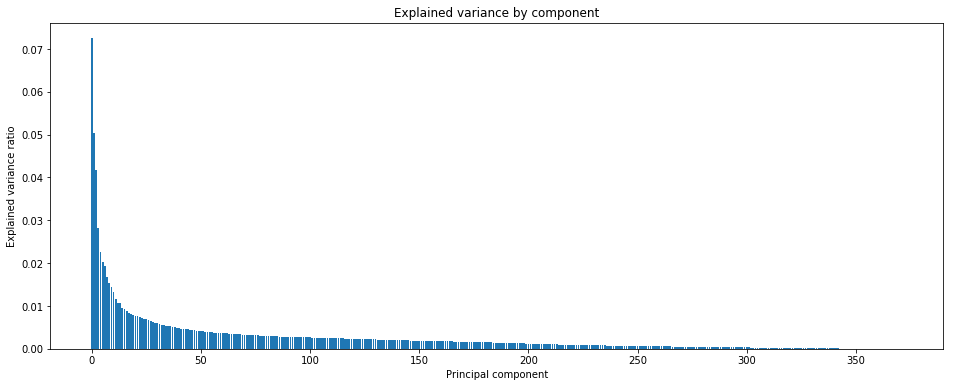

In [221]:
# Investigate the variance accounted for by each principal component.
plot_variance_by_component(azdias_pca_all)

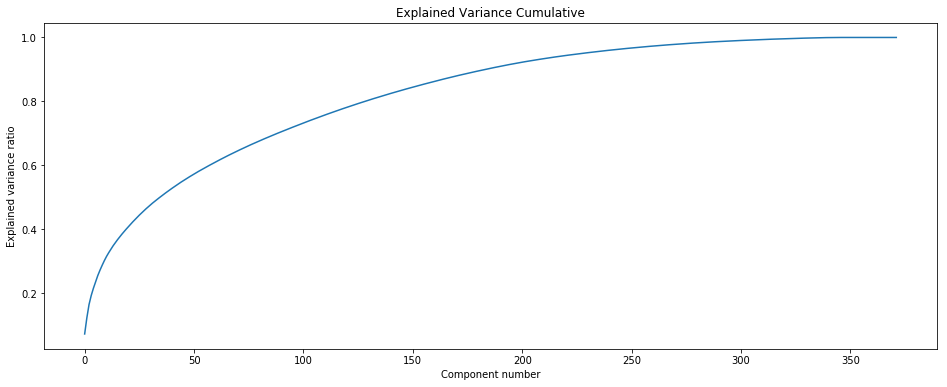

In [222]:
# Investigate the variance cumulative
variance_cumulative(azdias_pca_all)

In [223]:
# Re-run PCA to the data while selecting to retain 200 components.
azdias_pca_200, azdias_X_pca_200 = run_pca(200, azdias_final)

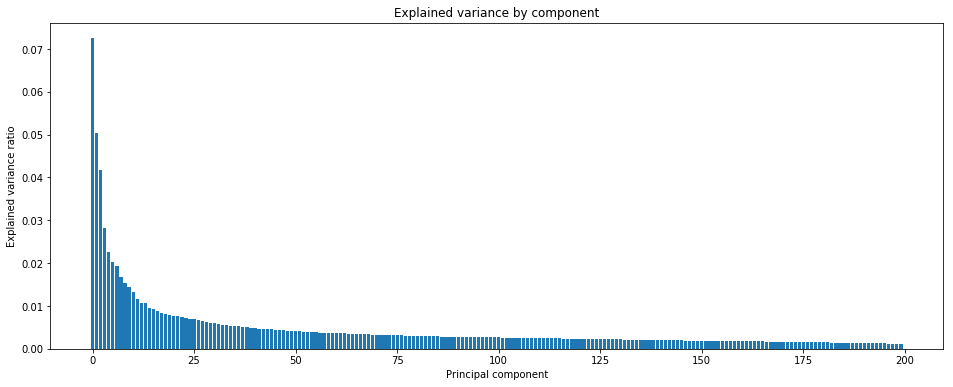

In [224]:
# Investigate the variance accounted for by each principal component when 200 components are used
plot_variance_by_component(azdias_pca_200)

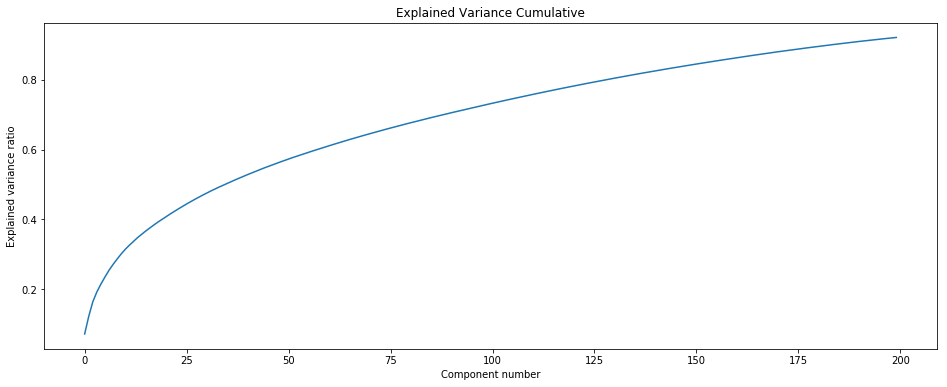

In [225]:
# Investigate the variance cumulative when 200 components are used
variance_cumulative(azdias_pca_200)

There is not clear way or algorithm how to choose the number of components. After searching on the internet it was suggested to choose the number of components to cover more than 85% of data variability. Also we can see the "elbow"  - when the curve stops growing enough might be an indicator of number of components to choose. Based on this and plots above I've chosen 200 components which explains ~90% of data variability.

In [226]:
# this function is taken from the classroom
def get_weights(pca, component_num, data):
    df = pd.DataFrame(pca.components_, columns = list(data.columns))
    weights = df.iloc[component_num].sort_values(ascending=False)
    return weights

In [227]:
# print relationship between azdias features and pca components
dimensions = len(azdias_pca_200.components_)
result = pd.DataFrame()
for dim in range(dimensions):
    df = get_weights(azdias_pca_200, dim, azdias_final)
    result = pd.concat([result, df], axis = 1)
result = result.T
result

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,AKT_DAT_KL,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VERS_TYP_2.0,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,0.061685,-0.044894,0.006216,0.082560,0.018750,-0.019993,-0.066403,0.081265,-0.002858,0.097653,...,0.011748,-0.043396,0.035563,0.070078,0.077700,0.076367,-0.033648,-0.051414,0.038327,0.086323
1,0.012643,-0.011014,0.003584,0.017683,0.025290,-0.001895,-0.010919,0.016505,0.010695,-0.041534,...,0.014094,-0.020887,0.038566,0.013864,0.019165,0.023975,-0.011043,-0.077651,0.007679,-0.008101
2,-0.043475,0.183221,-0.007481,0.020873,0.018160,-0.073116,-0.050505,0.023617,0.007833,0.041841,...,0.013705,0.005639,0.019634,0.074438,0.018822,-0.033881,0.060231,-0.033833,0.115158,-0.045467
3,-0.106800,0.000013,-0.010499,0.012805,0.012718,0.064957,0.151295,0.013133,0.012223,0.083989,...,0.007852,0.095100,-0.000097,-0.199277,-0.206650,-0.180525,0.007145,-0.068155,-0.104072,-0.052826
4,0.053871,-0.043447,0.007809,0.008293,0.010556,-0.019865,-0.066280,0.011072,-0.000100,0.057048,...,-0.016743,-0.034289,-0.026513,0.057622,0.055079,0.042884,-0.020845,-0.007316,0.027477,0.029311
5,-0.005962,-0.027054,-0.326011,-0.000834,0.002152,-0.026371,0.000703,-0.001987,0.005867,-0.003307,...,0.023803,-0.011630,0.002195,0.010227,-0.021169,-0.067704,0.006387,0.029985,0.053728,-0.040999
6,-0.006555,0.031338,0.074405,0.023700,0.008956,0.013064,0.013892,0.023014,0.000293,-0.027185,...,-0.021363,0.012891,-0.023466,-0.008684,-0.001927,0.009614,0.009364,0.084624,-0.024271,0.015409
7,0.020769,-0.036346,-0.022698,-0.015912,-0.015122,-0.006046,-0.016212,-0.015035,-0.005764,0.074646,...,0.014507,-0.025460,-0.037966,0.029088,0.030083,0.026429,0.000201,-0.107437,0.005209,-0.003979
8,0.020938,-0.037340,0.024109,-0.049111,0.007336,-0.015584,-0.042583,-0.048016,0.008042,0.032385,...,-0.011222,-0.020685,0.028624,0.025560,0.024043,0.016188,-0.018109,-0.017184,0.025800,-0.009461
9,0.014345,-0.006381,0.025440,-0.048925,-0.010821,-0.003416,-0.017326,-0.048495,0.005298,0.005933,...,-0.012142,-0.007010,0.016372,0.005414,0.004100,0.002106,-0.008803,0.047540,0.003519,-0.004318


In [228]:
def plot_weights_by_component(idx, pca_data):
    df = pd.DataFrame(pca_data.loc[idx].sort_values().reset_index())
    print(df)
    plt.rcParams["figure.figsize"] = [16,6]
    #plt.bar(result.loc[0].sort_values().index.tolist(), result.loc[0].sort_values().values.tolist())
    plt.bar(df.index.tolist(), result.loc[idx].sort_values().values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show()
    
    plt.rcParams["figure.figsize"] = [16,6]
    plt.bar(result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].index.tolist(), 
            result.loc[idx].sort_values().iloc[[0, 1, 2, -3, -2, -1]].values.tolist())
    plt.title("Weight by feature by component")
    plt.xlabel("Feature #")
    plt.ylabel("Feature Weight")
    plt.show()

From Term1: each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the i-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

                          index         0
0                    MOBI_REGIO -0.149186
1                    PLZ8_ANTG1 -0.147939
2                   KBA13_ANTG1 -0.147278
3                LP_STATUS_GROB -0.137545
4                   MOBI_RASTER -0.136049
5               KBA13_AUTOQUOTE -0.134481
6                KBA05_AUTOQUOT -0.133840
7                     KBA05_GBZ -0.131297
8             FINANZ_MINIMALIST -0.123515
9                   GEMEINDETYP -0.116723
10                    KBA13_GBZ -0.111661
11                     PLZ8_GBZ -0.110808
12         KBA13_ALTERHALTER_60 -0.106386
13                 KBA05_ANHANG -0.106023
14                  KONSUMNAEHE -0.104766
15                   INNENSTADT -0.102083
16              KBA13_HALTER_55 -0.101885
17              KBA13_HALTER_50 -0.094861
18                 FIRMENDICHTE -0.089613
19               KBA05_KRSAQUOT -0.086233
20               KBA13_KRSAQUOT -0.085313
21      KBA13_SEG_GELAENDEWAGEN -0.083086
22              KBA13_HALTER_60 -0

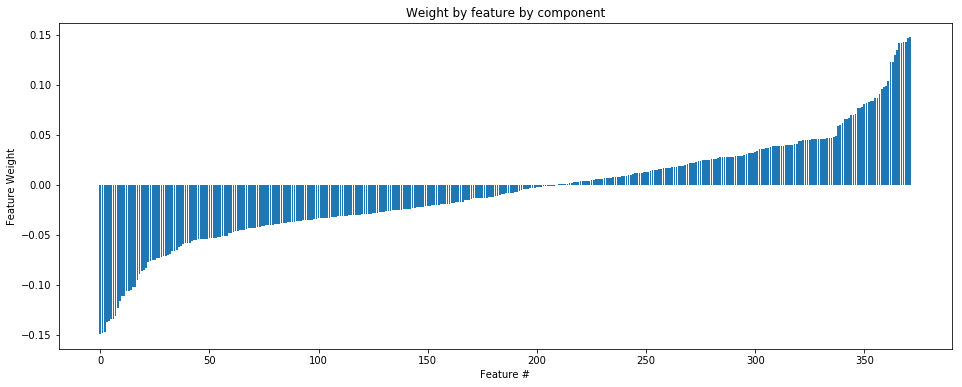

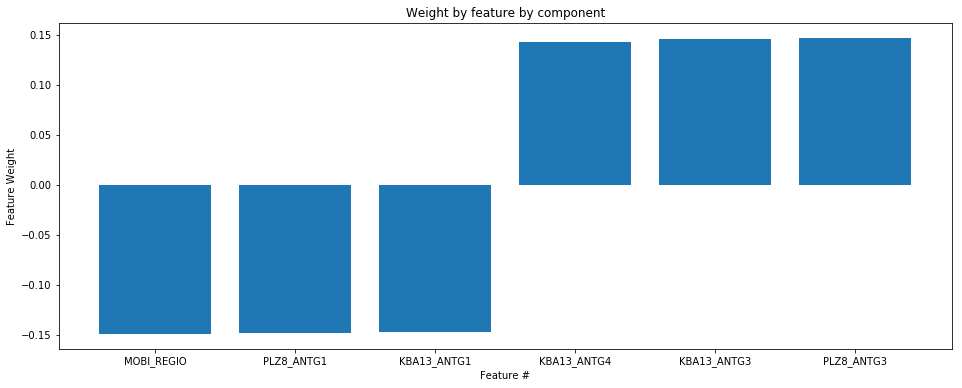

                           index         1
0                  KBA13_SITZE_5 -0.150044
1           KBA13_SEG_KLEINWAGEN -0.129678
2              KBA13_KMH_140_210 -0.126688
3                KBA13_HALTER_25 -0.120270
4        KBA13_SEG_KOMPAKTKLASSE -0.114177
5                  KBA13_KMH_180 -0.113616
6                KBA13_HALTER_20 -0.108612
7              KBA13_HERST_ASIEN -0.105938
8                  KBA13_KW_0_60 -0.102186
9          KBA13_HERST_FORD_OPEL -0.101504
10               KBA13_FAB_ASIEN -0.099269
11             KBA13_SEG_KLEINST -0.097256
12                KBA05_MAXHERST -0.094953
13                     KBA05_KW1 -0.091561
14          KBA13_ALTERHALTER_60 -0.089703
15                    KBA05_CCM1 -0.088982
16          KBA13_ALTERHALTER_30 -0.087320
17                           KKK -0.085186
18      KBA13_KRSHERST_FORD_OPEL -0.084702
19           KBA05_HERSTTEMP_3.0 -0.084461
20                  FIRMENDICHTE -0.083891
21                KBA13_CCM_1400 -0.083078
22         

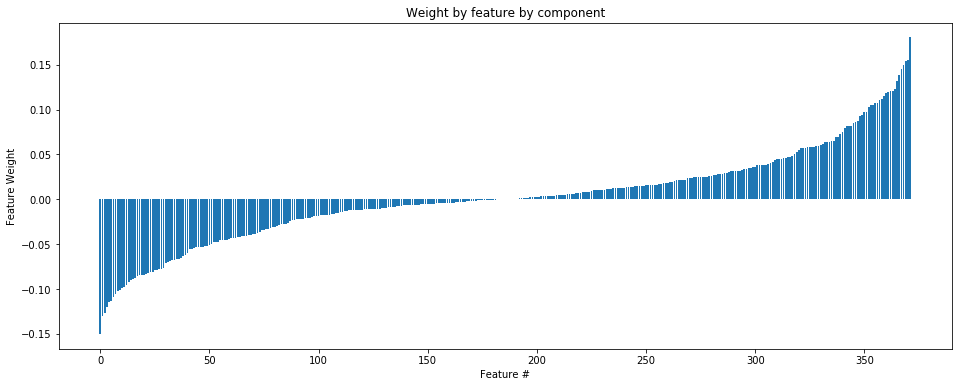

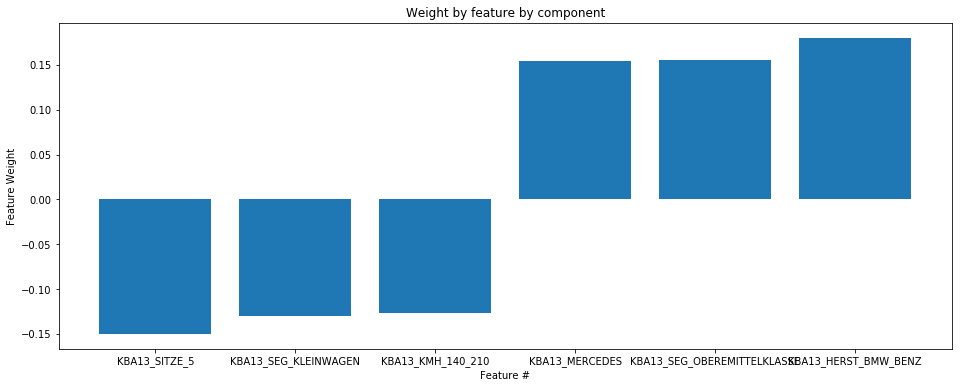

                     index         2
0                CJT_TYP_1 -0.203768
1            FINANZ_SPARER -0.200101
2                CJT_TYP_2 -0.197418
3    FINANZ_UNAUFFAELLIGER -0.180672
4           FINANZ_ANLEGER -0.179518
5            SEMIO_PFLICHT -0.178700
6              SEMIO_TRADV -0.169348
7                SEMIO_REL -0.161435
8                SEMIO_RAT -0.154826
9           RT_KEIN_ANREIZ -0.149963
10       ONLINE_AFFINITAET -0.138254
11         RT_UEBERGROESSE -0.135451
12           FINANZTYP_1.0 -0.126950
13           CJT_GESAMTTYP -0.109306
14              SEMIO_KULT -0.108264
15               SEMIO_MAT -0.098634
16              UMFELD_ALT -0.083141
17               SEMIO_FAM -0.081151
18    EINGEZOGENAM_HH_JAHR -0.075612
19              ANZ_KINDER -0.073116
20           FINANZTYP_4.0 -0.069001
21        D19_VERSAND_REST -0.065327
22          HEALTH_TYP_3.0 -0.063829
23        NATIONALITAET_KZ -0.063300
24              HEALTH_TYP -0.058738
25         LP_FAMILIE_GROB -0.058621
2

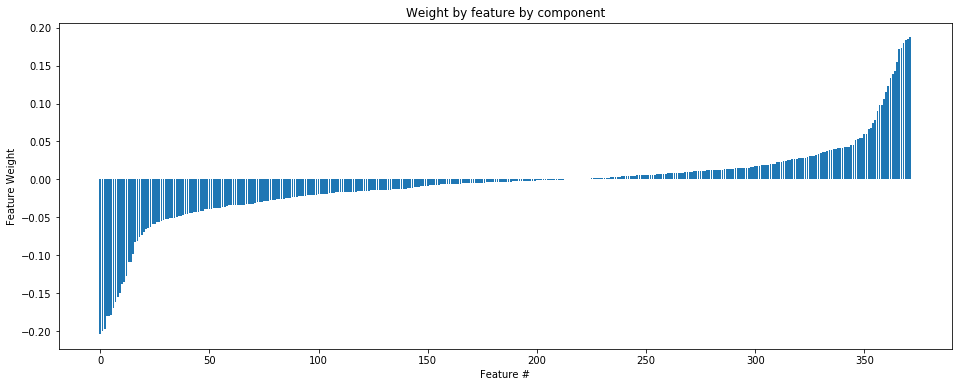

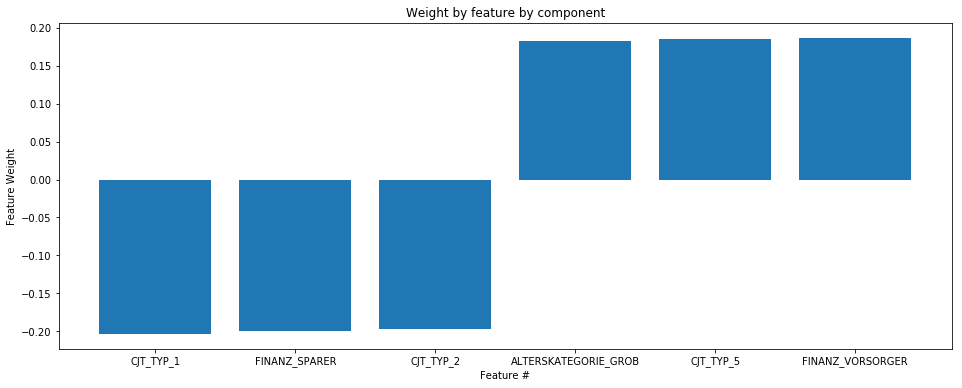

                       index         3
0                 VK_DISTANZ -0.206650
1                   VK_DHT4A -0.199277
2                    VK_ZG11 -0.180525
3          D19_KONSUMTYP_MAX -0.172421
4        LP_FAMILIE_GROB_1.0 -0.144570
5                 AKT_DAT_KL -0.106800
6             W_KEIT_KIND_HH -0.104072
7            D19_VERSI_DATUM -0.098115
8                OST_WEST_KZ -0.091121
9              KBA13_SITZE_6 -0.087045
10           KBA13_AUTOQUOTE -0.085297
11               GEMEINDETYP -0.084589
12                 KBA13_GBZ -0.077313
13                  PLZ8_GBZ -0.077166
14                INNENSTADT -0.076952
15         CJT_KATALOGNUTZER -0.074130
16           KBA13_HALTER_55 -0.073099
17           KBA13_HALTER_50 -0.072482
18      KBA13_ALTERHALTER_60 -0.071003
19               KBA13_ANTG1 -0.069963
20                PLZ8_ANTG1 -0.069238
21                       LNR -0.068653
22                  WOHNLAGE -0.068155
23   KBA13_SEG_GROSSRAUMVANS -0.066805
24       KBA13_HERST_AUDI

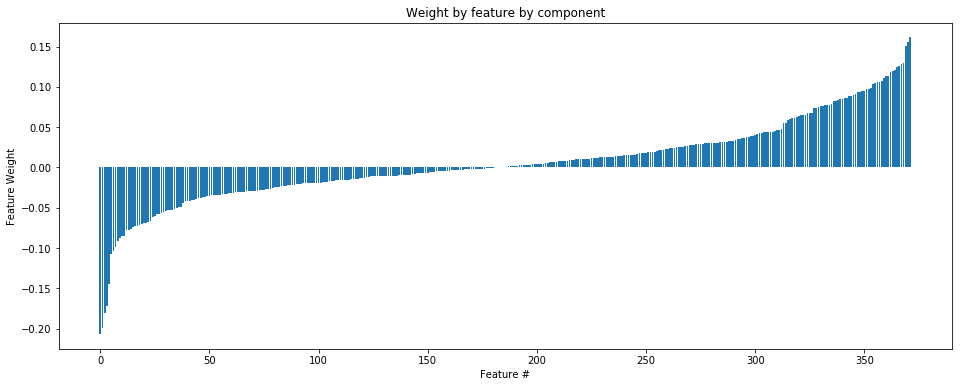

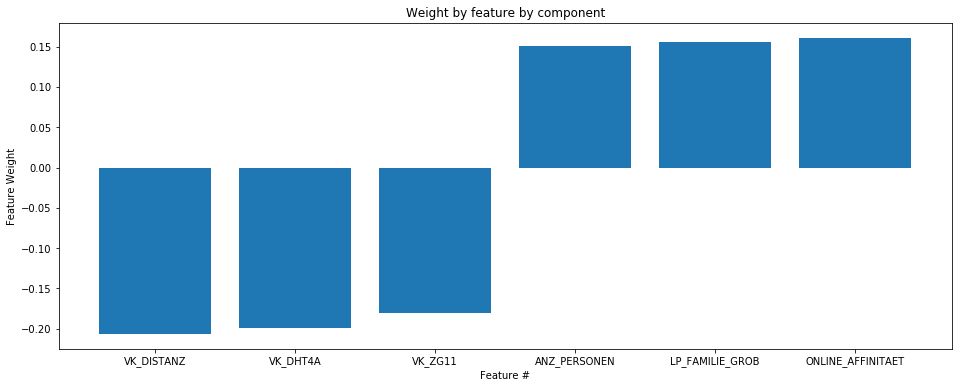

                        index         4
0               KBA13_KW_0_60 -0.202792
1               KBA13_BJ_2000 -0.164052
2               KBA13_KMH_180 -0.161086
3            KBA13_CCM_0_1400 -0.159805
4                 OST_WEST_KZ -0.149077
5               KBA13_KMH_140 -0.140297
6             KBA13_KMH_0_140 -0.135721
7                 KBA13_KW_40 -0.132870
8              KBA13_CCM_1000 -0.128181
9               KBA13_SITZE_4 -0.128028
10              KBA13_BJ_1999 -0.124688
11        KBA13_SEG_MINIWAGEN -0.120678
12                KBA13_KW_50 -0.117673
13               KBA13_VORB_2 -0.115124
14               KBA13_VORB_3 -0.114954
15                        LNR -0.111879
16             KBA13_CCM_1200 -0.111232
17                 KBA13_FIAT -0.099224
18            KBA13_HALTER_45 -0.098929
19             KBA13_CCM_1400 -0.096351
20              KBA13_SITZE_6 -0.095541
21                 KBA05_ZUL1 -0.091122
22          KBA13_SEG_KLEINST -0.082311
23         KBA13_KRSSEG_KLEIN -0.081820


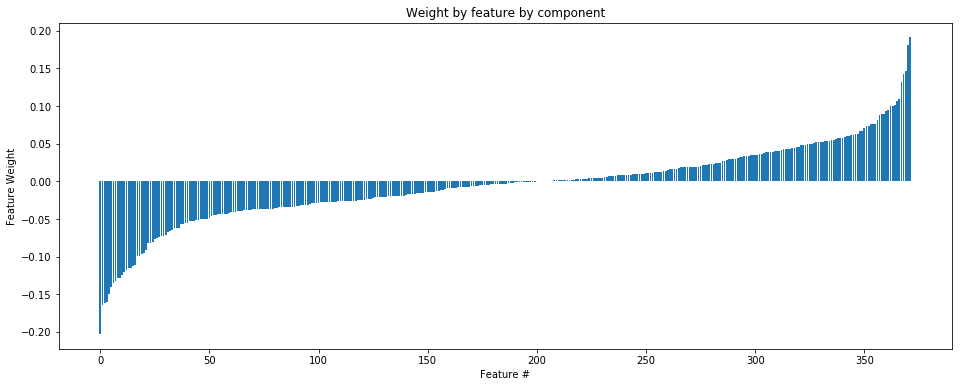

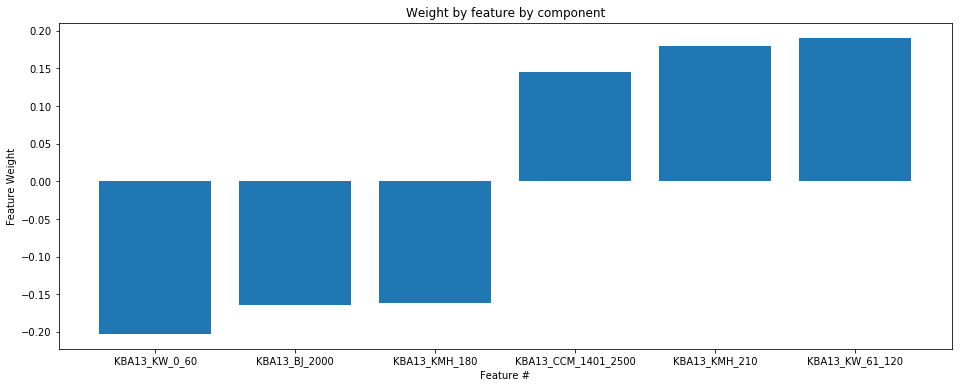

In [229]:
for i in range(5):
    plot_weights_by_component(i, result)

Component 1:
    Negative: MOBI_REGIO - Movement patterns
    Negative: PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region
    Negative: KBA13_ANTG1 - no column description
    Positive: KBA13_ANTG4 - no column description
    Positive: KBA13_ANTG3 - no column description
    Positive: PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region
Conclusion: even if there are half of the columns have no description we can guess that this component is related to people mobility: the less number of houses for 6 - 10 families are the more people tend to be mobile (easier to move)

Component 2:
   Negative: KBA13_SITZE_5 - number of cars with 5 seats in the PLZ8
   Negative: KBA13_SEG_KLEINWAGEN - share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
   Negative: KBA13_KMH_140_210 - share of cars with max speed between 140 and 210 km/h within the PLZ8
   Positive: KBA13_MERCEDES - share of MERCEDES within the PLZ8
   Positive: KBA13_SEG_OBEREMITTELKLASSE - share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
   Positive: KBA13_HERST_BMW_BENZ - share of BMW & Mercedes Benz within the PLZ8
Conslustion: simply saying we can say - the more expensive and upper class cars (BMW, Mercedes) in the area the less small cars there are (Ford Ka, Fiesta and etc) and vice-a-versa

Component 3:
   Negative: CJT_TYP_1 - no column description
   Negative: FINANZ_SPARER - financial typology: money saver
   Negative: CJT_TYP_2 - no column description
   Positive: ALTERSKATEGORIE_GROB - Estimated age based on given name analysis
   Positive: CJT_TYP_5 - no column description
   Positive: FINANZ_VORSORGER - financial typology: be prepared
Conclusion: difficult to interpret

Component 4: 
   Negative: VK_DISTANZ - no column description
   Negative: VK_DHT4A - no column description
   Negative: VK_ZG11 - no column description
   Positive: ANZ_PERSONEN - number of adult persons in the household
   Positive: LP_FAMILIE_GROB - family type rough
   Positive: ONLINE_AFFINITAET - online affinity
Conclusion: since the half of columns are not describe it's difficult to interpret. Some dependency between number of adult persons in a houshold and their online affinity with...

Component 5:
  Negative: KBA13_KW_0_60 - share of cars up to 60 KW engine power - PLZ8
  Negative: KBA13_BJ_2000 - share of cars built between 2000 and 2003 within the PLZ8
  Negative: KBA13_KMH_180 - share of cars with max speed between 110 km/h and 180km/h within the PLZ8
  Positive: KBA13_CCM_1401_2500 - share of cars with 1401ccm to 2500 ccm within the PLZ8
  Positive: KBA13_KMH_210 - share of cars with max speed less that 210 km/h within the PLZ8
  Positive: KBA13_KW_61_120 - share of cars with an engine power between 61 and 120 KW - PLZ8
Conclusion: the more fast and with powefull engines cars  are in the region the less old and weak and vice-a-versa

From term1: You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
Then, compute the average difference from each point to its assigned cluster's center. Hint: The KMeans object's .score() method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. Warning: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation.

In [230]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
def elbow_plot(data, start_K, end_K, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing K values from start_K to end_K every step value
    '''
    score_list = []

    for i in range(start_K, end_K, step):
        print(i)
        start = time.time()
        kmeans = KMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        score_list.append(abs(score))
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)
        print(score_list)

    plt.plot(range(start_K, end_K, step), 
    score_list, linestyle='--', marker='o', color='b');
    plt.xlabel('# of clusters K');
    plt.ylabel('Sum of squared errors');
    plt.title('SSE vs. K');
    plt.savefig('elbow_plot.png')

1
15.198655128479004
[250925502.39033875]
3
132.37301898002625
[250925502.39033875, 230759461.1325684]
5
331.8552179336548
[250925502.39033875, 230759461.1325684, 222694457.09321982]
7
303.48692083358765
[250925502.39033875, 230759461.1325684, 222694457.09321982, 217262299.94484004]
9
528.3004050254822
[250925502.39033875, 230759461.1325684, 222694457.09321982, 217262299.94484004, 213644135.18799433]
11
619.088634967804
[250925502.39033875, 230759461.1325684, 222694457.09321982, 217262299.94484004, 213644135.18799433, 211206971.604755]
13
723.3724946975708
[250925502.39033875, 230759461.1325684, 222694457.09321982, 217262299.94484004, 213644135.18799433, 211206971.604755, 209595718.68173102]
15
687.5506448745728
[250925502.39033875, 230759461.1325684, 222694457.09321982, 217262299.94484004, 213644135.18799433, 211206971.604755, 209595718.68173102, 208037592.5300899]
17
808.8093349933624
[250925502.39033875, 230759461.1325684, 222694457.09321982, 217262299.94484004, 213644135.18799433, 

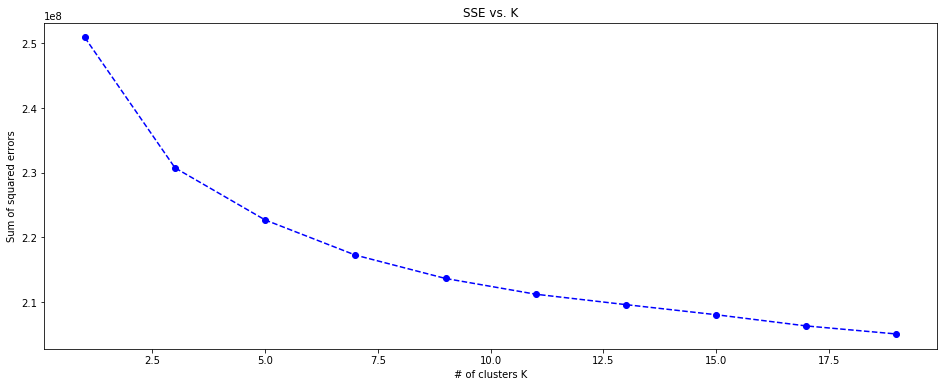

In [231]:
elbow_plot(azdias_X_pca_200, 1, 20, 2)

In [232]:
# Fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
azdias_kmeans = KMeans(11)
azdias_model = azdias_kmeans.fit(azdias_X_pca_200)
azdias_labels = azdias_model.predict(azdias_X_pca_200)

In [233]:
# view first few labels predicted for the azdias dataset
azdias_labels[0:30]

array([4, 0, 2, 0, 4, 8, 3, 3, 9, 4, 4, 3, 1, 8, 8, 3, 0, 7, 6, 8, 6, 7,
       9, 0, 4, 2, 9, 2, 2, 4], dtype=int32)

In [234]:
# Perform PCA on customers dataset
customers_pca_200 = azdias_pca_200.transform(customers_final)

In [235]:
# predict and print first few labels for the customers dataset
customers_labels = azdias_model.predict(customers_pca_200)
customers_labels[0:30]

array([ 7,  9,  0,  2,  3,  7,  7,  6,  7,  7,  0,  9,  7,  7,  2,  6,  7,
        9,  0,  6,  7,  2,  0,  3,  9,  6,  7,  2, 10,  0], dtype=int32)

## Compare Customer Data to Demographics Data

In [334]:
def calc_propotions(labels, population):
    counter = Counter(labels)
    proportions = [(i, counter[i] / population * 100.0) for i in counter]
    proportions.sort(key=itemgetter(0))
    proportions = np.array(proportions)
    
    dropped_gen_pop = 100 - round(proportions[:, 1].sum())
    if (dropped_gen_pop > 1):
        proportions = np.insert(proportions, 0, values=[dropped_gen_pop], axis=0)
    
    return proportions

In [335]:
customers_final.shape, azdias_final.shape

((134246, 372), (732827, 372))

In [336]:
# for azdias calculated the proportions of each cluster
general_population = 732827 #113601 #
azdias_proportions = calc_propotions(azdias_labels, general_population)
print(azdias_proportions)

[[ 0.         10.66063341]
 [ 1.          8.95381857]
 [ 2.         10.01423255]
 [ 3.          6.63307984]
 [ 4.         10.3320429 ]
 [ 5.          6.82589479]
 [ 6.          8.45329116]
 [ 7.         10.09133124]
 [ 8.          8.30919166]
 [ 9.         12.28543708]
 [10.          7.4410468 ]]


In [337]:
# for customers calculated the proportions of each cluster
general_population = 134246 #191652 #132907#
customers_proportions = calc_propotions(customers_labels, general_population)
print(customers_proportions)

[[ 0.         12.78324866]
 [ 1.          0.74266645]
 [ 2.         13.22571995]
 [ 3.         11.04315957]
 [ 4.          0.90058549]
 [ 5.          2.69430747]
 [ 6.          3.57552553]
 [ 7.         40.52932676]
 [ 8.          1.08234137]
 [ 9.         11.31355869]
 [10.          2.10956006]]


In [338]:
# calculate the ration between general population (azdias) and customers
# to see which customer segments are under and over represented
representation_ratio = customers_proportions[0:, 1]/azdias_proportions[0:, 1]
representation_ratio

array([1.1991078 , 0.0829441 , 1.32069231, 1.66486155, 0.08716432,
       0.39471858, 0.42297437, 4.01625175, 0.13025832, 0.92089183,
       0.28350313])

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'Customer Population/General Population')

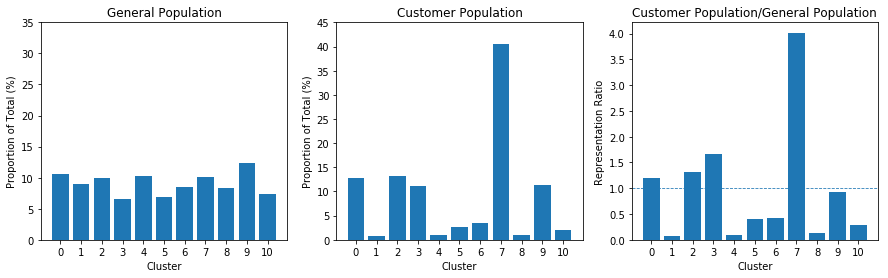

In [374]:
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(131)
ax1.bar(azdias_proportions[:, 0], azdias_proportions[:, 1])
ax1.set_xticks(azdias_proportions[:, 0])
ax1.set_ylim(ymax = 35)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
plt.title('General Population')

ax2 = plt.subplot(132)
ax2.bar(customers_proportions[:, 0], customers_proportions[:, 1])
ax2.set_xticks(azdias_proportions[:, 0])
ax2.set_ylim(ymax = 45)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
plt.title('Customer Population')

ax3 = plt.subplot(133)
ax3.bar(azdias_proportions[:, 0], representation_ratio)
ax3.set_xticks(azdias_proportions[:, 0])
ax3.set_xlabel("Cluster")
ax3.set_ylabel("Representation Ratio")
ax3.axhline(y=1, linestyle = "--", linewidth = 0.8)
plt.title('Customer Population/General Population')

In [398]:
tt = azdias_pca_200.inverse_transform(azdias_model.cluster_centers_[1])
c_1 = tt
underpresented = pd.Series(data = c_1, index = customers_final.columns).sort_values()
underpresented

HH_EINKOMMEN_SCORE      -1.192650
FINANZ_SPARER           -0.970735
RT_KEIN_ANREIZ          -0.945390
CJT_TYP_2               -0.938640
FINANZ_ANLEGER          -0.913505
CJT_TYP_1               -0.885793
VK_ZG11                 -0.796867
LP_STATUS_GROB_1.0      -0.760644
ZABEOTYP                -0.751922
SEMIO_PFLICHT           -0.670529
VK_DISTANZ              -0.656773
AKT_DAT_KL              -0.612893
SEMIO_REL               -0.593319
EINGEZOGENAM_HH_JAHR    -0.591682
PLZ8_BAUMAX             -0.574139
KBA13_BAUMAX            -0.573352
SEMIO_RAT               -0.570067
FINANZTYP_1.0           -0.546825
FINANZ_UNAUFFAELLIGER   -0.525163
SEMIO_TRADV             -0.524877
FINANZ_HAUSBAUER        -0.509232
KBA13_BJ_2000           -0.488568
D19_KONSUMTYP_MAX       -0.453633
KBA13_ANTG4             -0.451994
PLZ8_ANTG4              -0.449178
KBA05_ALTER1            -0.441137
KBA05_VORB2             -0.438955
SEMIO_MAT               -0.438435
WOHNLAGE                -0.437596
PLZ8_ANTG3    

In [399]:
tt = azdias_pca_200.inverse_transform(azdias_model.cluster_centers_[4])
c_4 = tt
underpresented = pd.Series(data = c_4, index = customers_final.columns).sort_values()
underpresented

CJT_TYP_6                 -0.982372
SEMIO_VERT                -0.950540
FINANZ_MINIMALIST         -0.935390
CJT_KATALOGNUTZER         -0.878232
CJT_TYP_3                 -0.799533
FINANZTYP                 -0.796499
CJT_TYP_5                 -0.791712
FINANZ_VORSORGER          -0.748491
SEMIO_SOZ                 -0.741862
ALTERSKATEGORIE_GROB      -0.721638
CJT_TYP_4                 -0.627172
RETOURTYP_BK_S            -0.568549
KOMBIALTER                -0.521130
FINANZTYP_6.0             -0.512810
SEMIO_LUST                -0.500989
PLZ8_BAUMAX               -0.489434
KBA13_BAUMAX              -0.484506
LP_STATUS_GROB            -0.425038
KBA13_ANTG4               -0.395914
PLZ8_ANTG4                -0.382717
CJT_GESAMTTYP_2.0         -0.362187
SEMIO_FAM                 -0.342524
FINANZTYP_5.0             -0.337017
PLZ8_ANTG3                -0.324681
D19_SONSTIGE              -0.323072
KBA13_HALTER_30           -0.322011
D19_REISEN                -0.316145
WOHNDAUER_2008            -0

In [400]:
tt = azdias_pca_200.inverse_transform(azdias_model.cluster_centers_[8])
c_8 = tt
underpresented = pd.Series(data = c_8, index = customers_final.columns).sort_values()
underpresented

SEMIO_ERL                 -1.159349
SEMIO_KAEM                -1.068573
ANREDE_KZ                 -1.042101
SEMIO_DOM                 -0.947323
SEMIO_KRIT                -0.907589
CJT_TYP_5                 -0.788835
FINANZ_VORSORGER          -0.777167
ALTERSKATEGORIE_GROB      -0.769472
KOMBIALTER                -0.731690
CJT_TYP_4                 -0.710852
SHOPPER_TYP               -0.672743
SEMIO_LUST                -0.582902
CJT_TYP_3                 -0.483615
RETOURTYP_BK_S            -0.482534
PLZ8_BAUMAX               -0.453947
KBA13_BAUMAX              -0.449117
CJT_GESAMTTYP_2.0         -0.433041
SHOPPER_TYP_2.0           -0.399102
SHOPPER_TYP_3.0           -0.387332
WOHNDAUER_2008            -0.360118
FINANZTYP_6.0             -0.358963
KBA13_ANTG4               -0.355755
PLZ8_ANTG4                -0.341641
FINANZTYP_2.0             -0.341626
CJT_GESAMTTYP_1.0         -0.326818
FINANZTYP                 -0.321042
KBA13_HALTER_30           -0.305808
FINANZ_MINIMALIST         -0

If we take a look at the at the grapths above we will see that the main and current customers are representers of clusters 0,2,3,7 from general population and clusters 1,4, and 8 are the least presented clusters from general population in the customers dataset. So we can say that representatives from general population 1,4 and 8 - our targets. Who are they? Let's check the features for each cluster with positive correlation. 
For cluster 1 we can say these are young people who earn very good, cares about ecology and environment and tend to save money, not to spend a lot. 
For the second cluster these are people with families, who are combining tradiotional and online shopping. 
And the cluster 8 : these are people also with families, with higher income, houses, religious and big cars (or minivans for family). So classical family in general terms.
Still is not a full picture since we dropped a lot of columns on clearning data stage and some columns is difficult to interpres without additional clarifications. For the next time, if I do this project, I would keep all the dropped catecogrial columns and dummied it, buit it would require much more computation power and probably this task is not for personal laptop :)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [340]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train = pd.read_csv('mailout_train.csv', sep=',')
del mailout_train['Unnamed: 0']

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [341]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [342]:
# Clean the training data
train = clean_data(mailout_train, feat_info_unknown)
train.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1763.0,1.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,0,1,0,0,0,0,0,1,0,1
1,1771.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,0,0,1,0,0,0,1,0,1,0
2,1776.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,...,1,1,0,0,0,0,0,1,1,0
3,1460.0,1.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,0,1,0,0,0,1,0,0,0,1
4,1783.0,1.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,0,1,0,0,0,1,0,0,1,0


In [343]:
train.columns.tolist()

['LNR',
 'AKT_DAT_KL',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'D19_VERSICHERUNG

In [344]:
# check the values variety on Response column
train['RESPONSE'].unique()

array([0., 1.])

In [345]:
# prepraring X and Y values to train models
y = train['RESPONSE']
del train['RESPONSE']
X = train
y.shape, X.shape

((33837,), (33837, 373))

In [346]:
y.value_counts()

0.0    33421
1.0      416
Name: RESPONSE, dtype: int64

It looks like that response column is quite imbalanced, only 1.2% (416/(33421+416)) people responded and 98.8% didn't responded. After searching on the internet it seems like using ROC AUC is a better choise than getting accuracy for getting a score for our models

In [347]:
# let's check what data types we have accross all columns and remove non-numerical for simplicity
(X.dtypes == 'object').sort_values()

LNR                            False
KOMBIALTER                     False
KKK                            False
KBA13_VW                       False
KBA13_VORB_3                   False
KBA13_VORB_2                   False
KBA13_VORB_1_2                 False
KBA13_VORB_1                   False
KBA13_VORB_0                   False
KBA13_TOYOTA                   False
KBA13_SITZE_6                  False
KBA13_SITZE_5                  False
KBA13_SITZE_4                  False
KBA13_SEG_WOHNMOBILE           False
KBA13_SEG_VAN                  False
KBA13_SEG_UTILITIES            False
KBA13_SEG_SPORTWAGEN           False
KBA13_SEG_SONSTIGE             False
KBA13_SEG_OBERKLASSE           False
KBA13_SEG_OBEREMITTELKLASSE    False
KONSUMNAEHE                    False
KBA13_SEG_MITTELKLASSE         False
KONSUMZELLE                    False
LP_STATUS_GROB                 False
RT_SCHNAEPPCHEN                False
RT_KEIN_ANREIZ                 False
RETOURTYP_BK_S                 False
R

In [348]:
# remove nun numerical columns for simplicity
del X['CAMEO_INTL_2015']
del X['EINGEFUEGT_AM']

In [349]:
# fill the missed values
imputer = Imputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
X.head()

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1763.0,1.0,15.0,0.000000,0.0,1.0,13.0,0.0,3.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1771.0,4.0,1.0,0.000000,0.0,2.0,1.0,0.0,2.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1776.0,1.0,0.0,0.047675,0.0,0.0,1.0,0.0,4.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1460.0,1.0,4.0,0.000000,0.0,2.0,4.0,0.0,4.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1783.0,1.0,53.0,0.000000,0.0,1.0,44.0,0.0,3.0,4.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [350]:
# print statistical info
X.describe()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
count,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,...,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000,33837.000000
mean,42913.725242,1.490646,6.532376,0.047675,0.086385,2.033927,6.068948,0.009339,3.042261,4.261221,...,0.251795,0.956645,0.019801,0.014008,0.176789,0.256051,0.177853,0.377486,0.502911,0.485268
std,24924.877564,1.685599,14.846768,0.366225,0.390153,1.365249,13.879059,0.102436,1.032325,2.192686,...,0.434051,0.203658,0.139317,0.117527,0.381495,0.436457,0.382394,0.484765,0.499999,0.499790
min,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21087.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,2.000000,2.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42563.000000,1.000000,2.000000,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,5.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,64853.000000,1.000000,7.000000,0.000000,0.000000,3.000000,6.000000,0.000000,4.000000,6.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,85795.000000,9.000000,438.000000,20.000000,6.000000,24.000000,369.000000,2.000000,9.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [351]:
# making sure we don't have missed values in the data
X.isnull().sum()

LNR                           0
AKT_DAT_KL                    0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
D19_BILDUNG                   0
D19_BIO_OEKO                  0
D19_BUCH_CD                   0
D19_DIGIT_SERV                0
D19_DROGERIEARTIKEL           0
D19_ENERGIE                   0
                             ..
KBA05_MA

In [352]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,-1.651014,-0.291086,0.570343,-1.301806e-01,-0.221416,-0.757329,0.499397,-0.091169,-0.040938,0.336934,...,-0.580114,0.212884,-0.142130,-0.119195,-0.463417,-0.586667,-0.465110,1.284174,-1.005839,1.029912
1,-1.650693,1.488724,-0.372637,-1.301806e-01,-0.221416,-0.024851,-0.365228,-0.091169,-1.009639,0.336934,...,-0.580114,-4.697386,7.035836,-0.119195,-0.463417,-0.586667,2.150031,-0.778711,0.994195,-0.970957
2,-1.650493,-0.291086,-0.439993,1.894737e-17,-0.221416,-1.489807,-0.365228,-0.091169,0.927763,-1.487340,...,1.723798,0.212884,-0.142130,-0.119195,-0.463417,-0.586667,-0.465110,1.284174,0.994195,-0.970957
3,-1.663171,-0.291086,-0.170570,-1.301806e-01,-0.221416,-0.024851,-0.149072,-0.091169,0.927763,-1.031271,...,-0.580114,0.212884,-0.142130,-0.119195,-0.463417,1.704544,-0.465110,-0.778711,-1.005839,1.029912
4,-1.650212,-0.291086,3.129860,-1.301806e-01,-0.221416,-0.757329,2.733010,-0.091169,-0.040938,-0.119134,...,-0.580114,0.212884,-0.142130,-0.119195,-0.463417,1.704544,-0.465110,-0.778711,0.994195,-0.970957


In [353]:
def classifier_roc(clf, param_grid, X=X, y=y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    scoring roc_auc available as parameter
    """    
    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print(end-start)

    print(grid.best_score_)
    
    return grid.best_estimator_

In [354]:
svc = SVC()
print(classifier_roc(svc, {}))

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", Futu

2664.4195289611816
0.6078593431601939
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


In [355]:
rfc = RandomForestClassifier()
print(classifier_roc(rfc, {}))

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

5.556419849395752
0.5159926338326815
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [356]:
ada = AdaBoostClassifier()
print(classifier_roc(ada, {}))

42.455617904663086
0.6702016891711374
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


In [357]:
gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, {}))

196.5504379272461
0.6958750942431421
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


So the GradientBoostingClassifier had the highest ROC AUC score among others - 0.6958 and time 196 secs. The second place is for AdaBoostClassifier which is slightly behind in terms of score - 0.67 but spent only 42 secs, 4.5 times faster. So I'm choosing AdaBoostClassifier to apply GridSearch on and it will be more practical in this case. 

In [358]:
start = time.time()

# parameters = {
#     "loss":["deviance"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": np.linspace(0.1, 0.5, 12),
#     "min_samples_leaf": np.linspace(0.1, 0.5, 12),
#     "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[0.5, 0.8, 1.0],
#     "n_estimators":[10]
#     }
param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [10, 50, 100]
             }

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid = param_grid, scoring='roc_auc', cv=10)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
cv_time = end - start
cv_time

0.7200803896541077
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


759.1756348609924

After performing optimization we got ROC AUC result increased from 0.67 to 0.72 (~7%) which is not bad result.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [360]:
mailout_test = pd.read_csv('mailout_test.csv', sep=',')
del mailout_test['Unnamed: 0']

/Users/epifanov/anaconda3/envs/deep-learning/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [361]:
# this is the same method as we already used but without removing rows since we need to predict on all the rows
def clean_data_no_rows_removal(df, df_info):
    
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col] = df[col].astype(np.float64)
            
    for row in df_info['attribute']:
        if row in df.columns:
            na_map = df_info.loc[df_info['attribute'] == row, 'missing_or_unknown'].iloc[0]
            #na_map = list(map(str.strip, na_map.strip('][').replace("'", '').split(',')))
            na_idx = df.loc[:, row].isin(na_map)
            df.loc[na_idx, row] = np.NaN
        else:
            continue
            
   
    cols_2drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 
     'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 
     'D19_BANKEN_OFFLINE_DATUM',
     'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
     'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12',
     'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12',
     'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
     'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
     'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12',
     'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
     'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
   
    df.drop(cols_2drop, axis=1, inplace = True)
    
    df['OST_WEST_KZ'].replace(['W', 'O'], [1.0, 0.0], inplace=True)
    for col in df.columns:
        if df[col].dtype == np.int64:
            df[col] = df[col].astype(np.float64)

    categorical = ['ANREDE_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP',
     'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 
     'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 
     'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'OST_WEST_KZ', 
     'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP' ]
    
    columns_2drop = ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN',
                     'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
    columns_2dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                        'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                        'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    df.drop(columns_2drop, axis=1, inplace = True)
    
    for col in columns_2dummy:
        dummy = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dummy], axis = 1)
    return df

In [362]:
# print first few lines
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [363]:
# perform dataset clearning
mailout_test = clean_data_no_rows_removal(mailout_test, feat_info_unknown)

In [364]:
# save LNR for later usage for kaggle submission preparation
mailout_test_LNR = mailout_test['LNR']

In [365]:
# making sure we don't have unncessary types
mailout_test.dtypes.sort_values()

VERS_TYP_2.0                uint8
KBA05_HERSTTEMP_2.0         uint8
KBA05_HERSTTEMP_1.0         uint8
HEALTH_TYP_3.0              uint8
HEALTH_TYP_2.0              uint8
HEALTH_TYP_1.0              uint8
GEBAEUDETYP_RASTER_5.0      uint8
GEBAEUDETYP_RASTER_4.0      uint8
GEBAEUDETYP_RASTER_3.0      uint8
GEBAEUDETYP_RASTER_2.0      uint8
GEBAEUDETYP_RASTER_1.0      uint8
GEBAEUDETYP_8.0             uint8
GEBAEUDETYP_6.0             uint8
GEBAEUDETYP_4.0             uint8
KBA05_HERSTTEMP_3.0         uint8
GEBAEUDETYP_3.0             uint8
GEBAEUDETYP_1.0             uint8
FINANZTYP_6.0               uint8
FINANZTYP_5.0               uint8
FINANZTYP_4.0               uint8
FINANZTYP_3.0               uint8
FINANZTYP_2.0               uint8
FINANZTYP_1.0               uint8
CJT_GESAMTTYP_6.0           uint8
CJT_GESAMTTYP_5.0           uint8
CJT_GESAMTTYP_4.0           uint8
CJT_GESAMTTYP_3.0           uint8
CJT_GESAMTTYP_2.0           uint8
CJT_GESAMTTYP_1.0           uint8
GEBAEUDETYP_2.

In [366]:
# remove columns with strings for cimplicity
del mailout_test['CAMEO_INTL_2015']
del mailout_test['EINGEFUEGT_AM']

In [367]:
# filling missing values
mailout_test = pd.DataFrame(imputer.transform(mailout_test), columns = mailout_test.columns)
mailout_test.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1754.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1770.0,1.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1465.0,9.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1470.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,1478.0,1.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [368]:
mailout_test.describe()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
count,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,...,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000,42833.000000
mean,42993.165620,1.514348,6.711237,0.046048,0.090050,2.025161,6.285011,0.010677,3.040131,4.282259,...,0.213083,0.802676,0.016926,0.011697,0.142227,0.213854,0.153550,0.319193,0.431583,0.397240
std,24755.599728,1.591631,13.454072,0.305430,0.366525,1.244138,12.734125,0.103488,0.944615,1.981039,...,0.409491,0.397984,0.128996,0.107518,0.349287,0.410030,0.360521,0.466169,0.495303,0.489332
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21650.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,3.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,43054.000000,1.000000,3.000000,0.000000,0.000000,2.000000,3.000000,0.000000,3.000000,4.261221,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,64352.000000,1.490646,6.532376,0.000000,0.000000,2.033927,6.068948,0.000000,4.000000,6.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,85794.000000,9.000000,379.000000,20.000000,7.000000,14.000000,375.000000,3.000000,9.000000,7.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [369]:
# make sure we don't have missed values in the dataset
mailout_test.isnull().sum()

LNR                           0
AKT_DAT_KL                    0
ANZ_HAUSHALTE_AKTIV           0
ANZ_HH_TITEL                  0
ANZ_KINDER                    0
ANZ_PERSONEN                  0
ANZ_STATISTISCHE_HAUSHALTE    0
ANZ_TITEL                     0
ARBEIT                        0
BALLRAUM                      0
CJT_GESAMTTYP                 0
CJT_KATALOGNUTZER             0
CJT_TYP_1                     0
CJT_TYP_2                     0
CJT_TYP_3                     0
CJT_TYP_4                     0
CJT_TYP_5                     0
CJT_TYP_6                     0
D19_BANKEN_DIREKT             0
D19_BANKEN_GROSS              0
D19_BANKEN_LOKAL              0
D19_BANKEN_REST               0
D19_BEKLEIDUNG_GEH            0
D19_BEKLEIDUNG_REST           0
D19_BILDUNG                   0
D19_BIO_OEKO                  0
D19_BUCH_CD                   0
D19_DIGIT_SERV                0
D19_DROGERIEARTIKEL           0
D19_ENERGIE                   0
                             ..
KBA05_MA

In [370]:
# get our best model after optimization
best_model = grid.best_estimator_

In [371]:
# train the model
best_model.fit(X, y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)

In [372]:
# and predict
preds = best_model.predict_proba(mailout_test)
preds[:10]

array([[0.73924607, 0.26075393],
       [0.73924607, 0.26075393],
       [0.74046512, 0.25953488],
       [0.74069049, 0.25930951],
       [0.74669398, 0.25330602],
       [0.74069049, 0.25930951],
       [0.74755347, 0.25244653],
       [0.74903998, 0.25096002],
       [0.74669398, 0.25330602],
       [0.74527149, 0.25472851]])

In [373]:
kaggle = pd.DataFrame({'LNR':mailout_test_LNR.astype(np.int32), 'RESPONSE':preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()

,LNR,RESPONSE
0,1754,0.260754
1,1770,0.260754
2,1465,0.259535
3,1470,0.259310
4,1478,0.253306


## Conclusions

### Reflection
The goal of this project was to apply unsupervised learning techniques to identify segments of the population that form the core customer base and determine population segments of potential customers

Comparing to the project from the Term1 - this is much more difficult by many reasons. One of this is here we have bigger dataset and more columns, which meaning, especially without a dictionary we had in the previous project. is really difficult to understand/guess. So not having a description on some colums made a big impact on understanding pca analysis results and clustering. In my case I see the dominance on finance type, shopping type and income columns on others, like cars related for example, which is flustrating a bit while analysing PCA components there were a clear picture on expencieve and cheap cars relationship. But due to not having a description for other columns it made these interpritaions led nowhere. 
And regarding overall data cleaning - of course, to get better and clear results it would require more feature engineering work - not just dropping columns with more than 10 unique values, but rather dumming them and recode if needed. For sure it would require more computation power and probably this task won't be suitable for an average laptop but would require something more powerfull.

### Improvements
 - do more feature engineering work and remove less columns and rows
 - re-encode some columns to keep more data inside for analysis
 - try different Imputation methods, not only mean but rather check Model based imputations
 - try more classification models and select more parameters for better optimization